# node2vec

This notebook demonstrates how to train a node embedding models using Gensim's word2vec model.  The embeddings would be used to extract relationship between entities in downstream task.

The random walk will be used an input while skip-gram model would be employed to train the embeddings.

In [1]:
import pandas as pd
import tqdm as tq
import gensim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = "/Users/apple/Google Drive/_My Data Analytics Exercise/Exercise/Cytoscape/KEGG enzymes/"

In [3]:
# The sentence is 
# "L-glutamate catalyses 
# ATP and L-cysteine 
# to produce 
# ADP and phosphate and gamma-L-glutamyl-L-cysteine"
nodes = ['L-glutamate', 'catalyses', 'ATP', 'and', 'L-cysteine', 'to', 'produce', 'ADP', 'phosphate', 'gamma-L-glutamyl-L-cysteine']

In [4]:
df = pd.read_csv(PATH+"RandomWalk_new.csv")

In [5]:
df.head()

,path
0,"['L-glutamate', 'catalyses', 'L-cysteine', 'AT..."
1,"['L-glutamate', 'catalyses', 'L-glutamate', 'c..."
2,"['L-glutamate', 'catalyses', 'L-glutamate', 'c..."
3,"['L-glutamate', 'catalyses', 'ATP', 'catalyses..."
4,"['L-glutamate', 'catalyses', 'L-glutamate', 'c..."


In [6]:
from tqdm import tqdm
def generate_corpus(df, nodes):
    """extract texts from dataframe into proper corpus"""
    text = list()
    collection = list()
    for i in tqdm(range(len(df))):
        sent = df.loc[i, 'path']
        for t in sent.split(","):
            for node in nodes:
                if node in t:
                    text.append(node)
        collection.append(text)
    return collection

In [7]:
corpus = generate_corpus(df, nodes)

100%|██████████| 10000/10000 [00:00<00:00, 11206.91it/s]


In [8]:
type(corpus)

list

In [9]:
from gensim.models import Word2Vec

In [10]:
import time
start = time.time()
model = Word2Vec(sentences=corpus, window=5, min_count=1, workers=20)
sec = time.time()-start
print ("Processing time: %.2f" %sec)

Processing time: 5155.42


In [11]:
model.save(PATH+"node2vec.model")

In [12]:
# Similarity comparison
for node in nodes:
    print ("Token = %s" %node)
    print (model.wv.similar_by_word(node))
    print ()

Token = L-glutamate
[('ATP', 0.9015867710113525), ('catalyses', 0.7822502255439758), ('L-cysteine', 0.44333961606025696), ('and', 0.43267035484313965), ('produce', -0.567520797252655), ('to', -0.5824844241142273), ('gamma-L-glutamyl-L-cysteine', -0.6789444088935852), ('phosphate', -0.8330023884773254), ('ADP', -0.8503132462501526)]

Token = catalyses
[('ATP', 0.8153453469276428), ('L-glutamate', 0.7822503447532654), ('L-cysteine', 0.5319836139678955), ('and', 0.49587950110435486), ('to', -0.5047869682312012), ('produce', -0.6949671506881714), ('gamma-L-glutamyl-L-cysteine', -0.7260816097259521), ('phosphate', -0.726341962814331), ('ADP', -0.7519031167030334)]

Token = ATP
[('L-glutamate', 0.9015867710113525), ('catalyses', 0.815345287322998), ('L-cysteine', 0.4332292675971985), ('and', 0.3949184715747833), ('to', -0.4890885651111603), ('produce', -0.7638189196586609), ('ADP', -0.7748681306838989), ('phosphate', -0.8612366914749146), ('gamma-L-glutamyl-L-cysteine', -0.884052574634552)]


From above similarity score, one can classify which entity should appear on the left-handed side or the right-handed side of the reaction equation.

## Distribution of the Node Vector

After obtaining the embedding for each node, the following script is used to review how each node is located relative to each other in a 2-dimensional space.

In [13]:
model = Word2Vec.load(PATH+"node2vec.model")

In [14]:
node_vec = dict()
for node in nodes:
    vec = model.wv[node]
    node_vec[node] = vec

In [15]:
import numpy as np
x = list()
y = list()
for key, values in node_vec.items():
    x.append(values)
    y.append(key)

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

In [31]:
llm = LocallyLinearEmbedding(n_components=2, method='modified')

In [32]:
X_transformed = llm.fit_transform(x)

In [19]:
X_transformed.shape

(10, 2)

In [20]:
X_transformed[0]

array([-0.41707719,  0.10612305])

In [21]:
y[0]

'L-glutamate'

In [22]:
import matplotlib.pyplot as plt

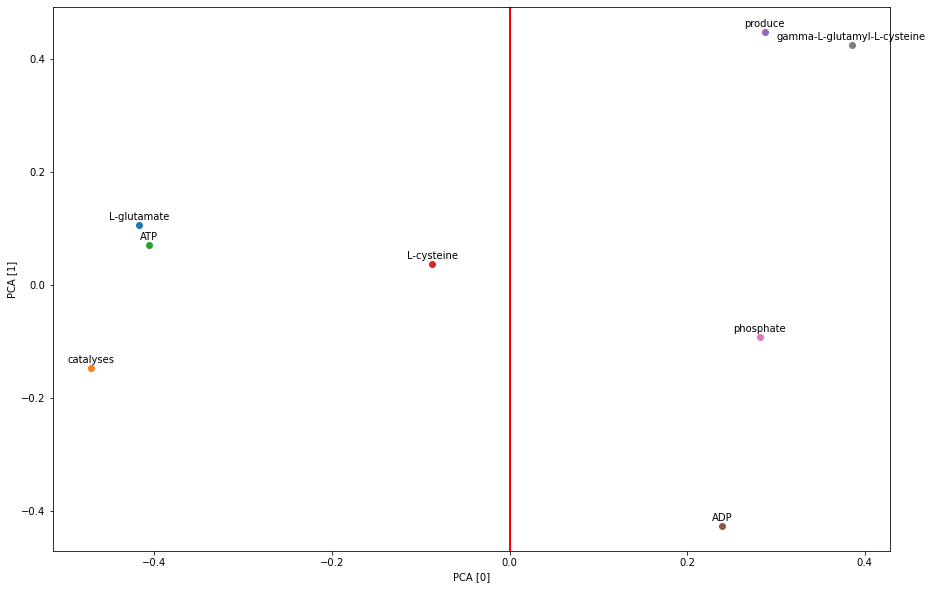

In [33]:
plt.figure(figsize=(15,10))
for index, pca  in enumerate(X_transformed):
    label = y[index]
    if label == 'and' or label == 'to':
        pass
    else:
        plt.scatter(pca[0], pca[1])
        plt.annotate(label, # this is the text
                     (pca[0],pca[1]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        #plt.axhline(y=0.0, color='r', linestyle='-')
        plt.axvline(x=0.0, color='r', linestyle='-')
        plt.xlabel('PCA [0]')
        plt.ylabel('PCA [1]')
plt.show()

From above plot, it's obvious that the embeddings are able to delineate different entities into two distinct groups. The embeddings could be tuned further by having different conversion approach to generate graph from sentence.